In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

C:\Users\zlism\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 140s 1us/step


In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


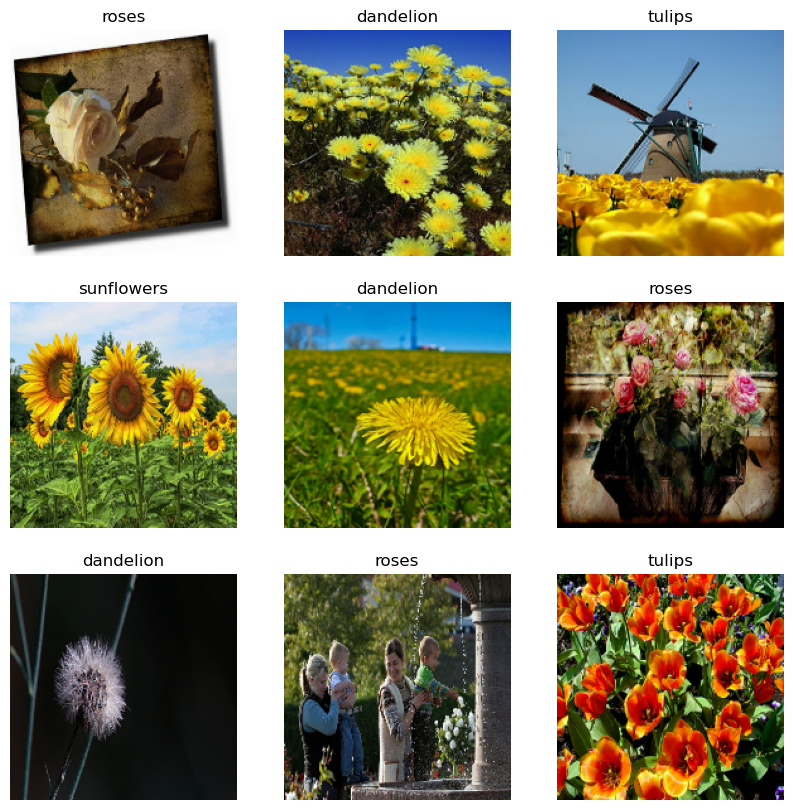

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\zlism\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.3233 - loss: 1.5578 - val_accuracy: 0.5531 - val_loss: 1.1346
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.5953 - loss: 1.0240 - val_accuracy: 0.6049 - val_loss: 0.9861
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.7002 - loss: 0.7965 - val_accuracy: 0.6308 - val_loss: 0.9382
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.7648 - loss: 0.6295 - val_accuracy: 0.6049 - val_loss: 1.0134
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.8632 - loss: 0.4039 - val_accuracy: 0.6526 - val_loss: 0.9979
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.9292 - loss: 0.2301 - val_accuracy: 0.6458 - val_loss: 1.2065
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.9667 - loss: 0.1388 - val_accuracy: 0.6417 - val_loss: 1.3195
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.9743 - loss: 0.0796 - val_accu

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

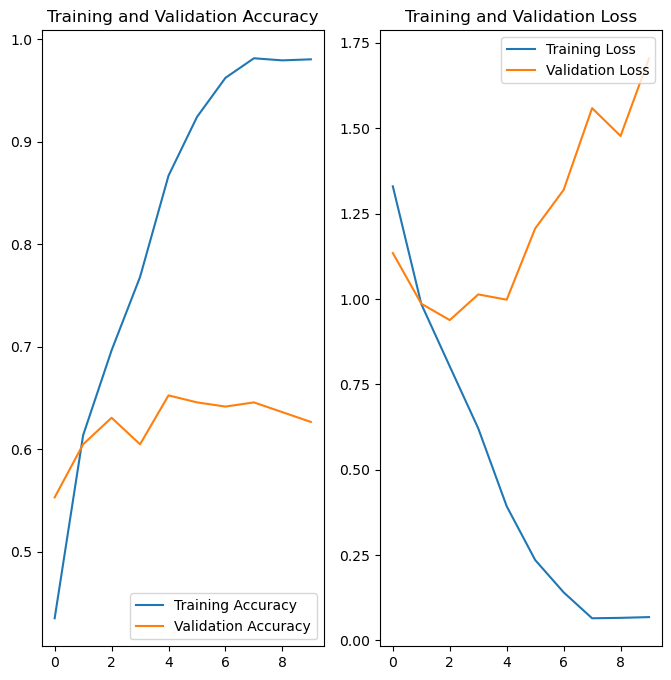

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

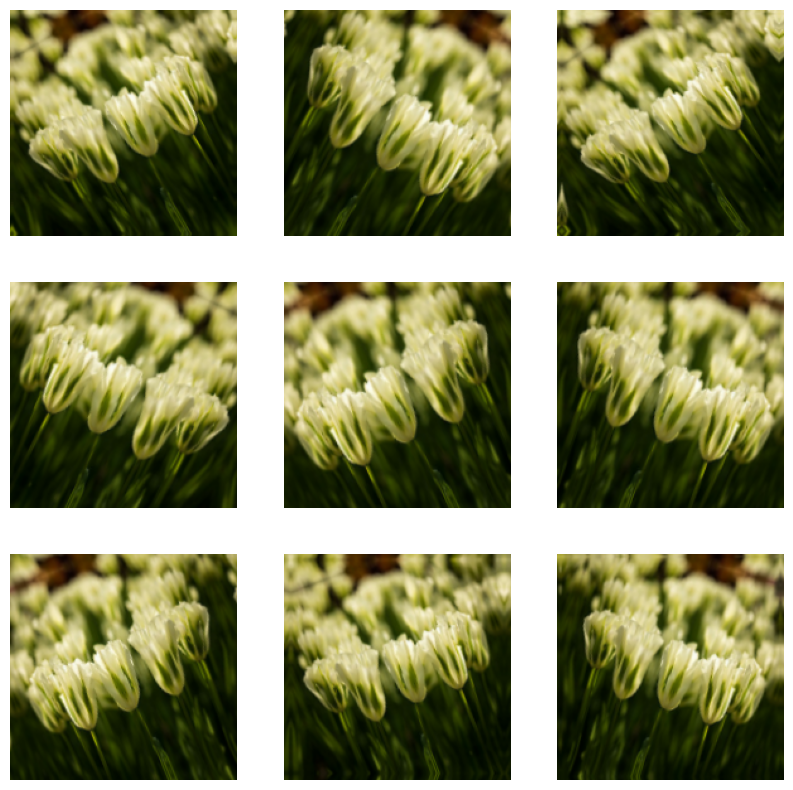

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.7628 - loss: 0.6225 - val_accuracy: 0.7057 - val_loss: 0.7657
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.7611 - loss: 0.6101 - val_accuracy: 0.7316 - val_loss: 0.7038
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.7820 - loss: 0.5764 - val_accuracy: 0.7180 - val_loss: 0.7438
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - accuracy: 0.8054 - loss: 0.5431 - val_accuracy: 0.7289 - val_loss: 0.6915
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 0.7832 - loss: 0.5682 - val_accuracy: 0.7316 - val_loss: 0.6729
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.8140 - loss: 0.5188 - val_accuracy: 0.7411 - val_loss: 0.6778
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.8165 - loss: 0.4911 - val_accuracy: 0.7343 - val_loss: 0.6761
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.8107 - loss: 0.4952 - val_accu

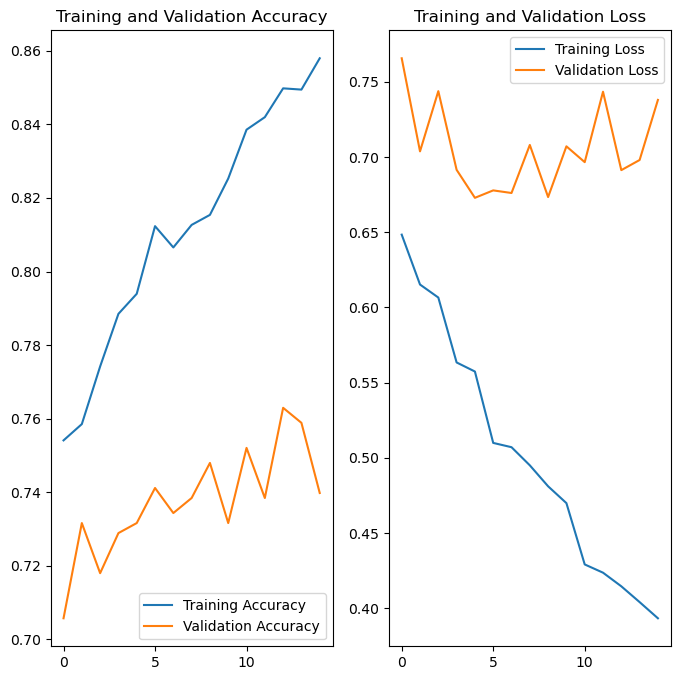

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
This image most likely belongs to sunflowers with a 99.57 percent confidence.


In [26]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\zlism\AppData\Local\Temp\tmpecm1kvzu\assets


INFO:tensorflow:Assets written to: C:\Users\zlism\AppData\Local\Temp\tmpecm1kvzu\assets


Saved artifact at 'C:\Users\zlism\AppData\Local\Temp\tmpecm1kvzu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2002353612624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002353611664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002353609168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002353612240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002353610320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002353611088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002353612816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002353613392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002353613584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2002353614160: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [27]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [28]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_19'], 'outputs': ['output_0']}}

In [30]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [51]:
predictions_lite = classify_lite(keras_tensor_19=img_array)['output_0']
score_lite = tf.nn.softmax(predictions_lite)

In [52]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 99.57 percent confidence.


In [53]:
print(np.max(np.abs(predictions - predictions_lite)))

3.8146973e-06


### Performance Scheduling - Accuracy up to 75%

In [80]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[180, 180,3]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [81]:
n_epochs = 15
history = model.fit(train_ds, epochs=n_epochs,
                    validation_data=val_ds)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.2543 - loss: 4939.1553 - val_accuracy: 0.3924 - val_loss: 372.8840
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step - accuracy: 0.3725 - loss: 524.3740 - val_accuracy: 0.4292 - val_loss: 210.8208
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.4322 - loss: 288.1764 - val_accuracy: 0.3515 - val_loss: 370.3663
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.4510 - loss: 197.9969 - val_accuracy: 0.3896 - val_loss: 182.1788
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 0.4949 - loss: 138.6458 - val_accuracy: 0.4033 - val_loss: 161.3076
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.5294 - loss: 98.1211 - val_accuracy: 0.4264 - val_loss: 116.8026
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.5663 - loss: 66.2786 - val_accuracy: 0.2125 - val_loss: 169.1092
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.546